# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
from plotnine import *

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# print shapes
print("user-item dataframe has  \x1b[31m{x}\x1b[0m rows and  \x1b[31m{y}\x1b[0m columns".format(x=df.shape[0], y=df.shape[1]))
print()
print("content dataframe has \x1b[31m{x}\x1b[0m rows and  \x1b[31m{y}\x1b[0m columns".format(x=df_content.shape[0], y=df_content.shape[1]))

user-item dataframe has  45993 rows and  3 columns

content dataframe has 1056 rows and  5 columns


In [4]:
# print column names of each
print("user-item dataframe has \x1b[31m {} \x1b[0m columns".format(df.columns.values))
print()
print("content dataframe has \x1b[31m {} \x1b[0m columns".format(df_content.columns.values))


# for more on printing with colors
# https://stackoverflow.com/questions/16816013/is-it-possible-to-print-using-different-colors-in-ipythons-notebook

user-item dataframe has  ['article_id' 'title' 'email']  columns

content dataframe has  ['doc_body' 'doc_description' 'doc_full_name' 'doc_status' 'article_id']  columns


In [5]:
# mostly reviewed 10 articles.
df.article_id.value_counts().head(10)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: article_id, dtype: int64

In [6]:
articles_per_user = df.groupby("email")["article_id"].count().reset_index()
users_per_article = df.groupby("article_id")["email"].count().reset_index()

In [7]:
articles_per_user.sort_values("article_id",ascending=False, inplace=True)
users_per_article.sort_values("email",ascending=False, inplace=True)

In [8]:
# top 5 most active users
articles_per_user.head()

,email,article_id
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


In [9]:
# top 5 most read articles
users_per_article.head()

,article_id,email
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627


In [10]:
articles_per_user.head()

,email,article_id
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


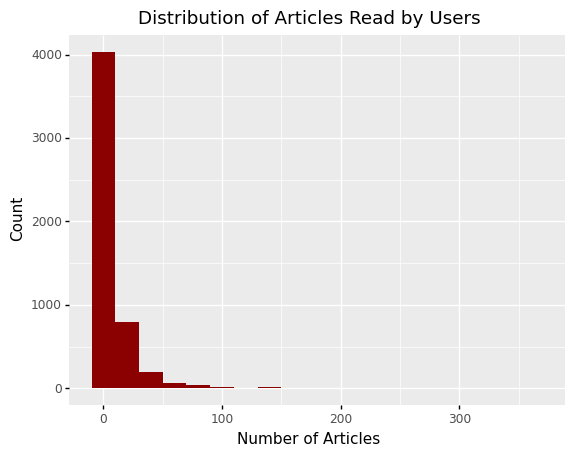

<ggplot: (8787550196129)>

In [11]:
(ggplot(articles_per_user, aes(x="article_id")) +
 geom_histogram(binwidth=20, fill="darkred") +
 ggtitle("Distribution of Articles Read by Users") +
 xlab("Number of Articles") +
 ylab("Count")
 )

Majority of the users read less than 20 articles. I picked the binwidth as 20, so don't see it in higher resolution. Yet I am almost sure that it it's a zero-inflated poisson distribution

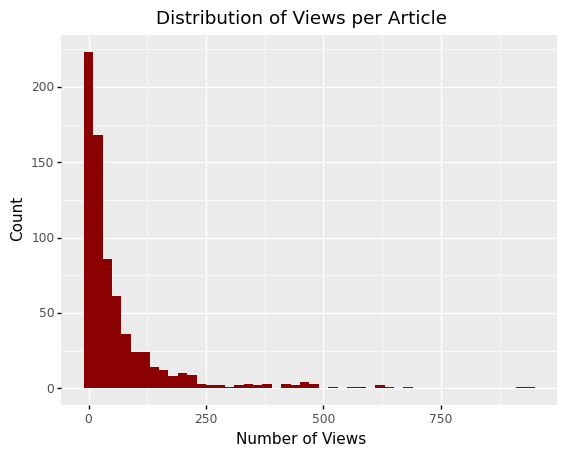

<ggplot: (8787550075917)>

In [12]:
(ggplot(users_per_article, aes(x="email")) +
 geom_histogram(binwidth=20, fill="darkred") +
 ggtitle("Distribution of Views per Article") +
 xlab("Number of Views") +
 ylab("Count")
 )

A similar story goes for number of views as well. Just the numbers are little bit compressed on each axes.

In [13]:
article_length = []
for article in df_content.doc_body:
    article_length.append(len(str(article)))
article_length = pd.Series(data=article_length).\
    sort_values(ascending=False).\
    reset_index().\
    rename(columns={0:"len"})

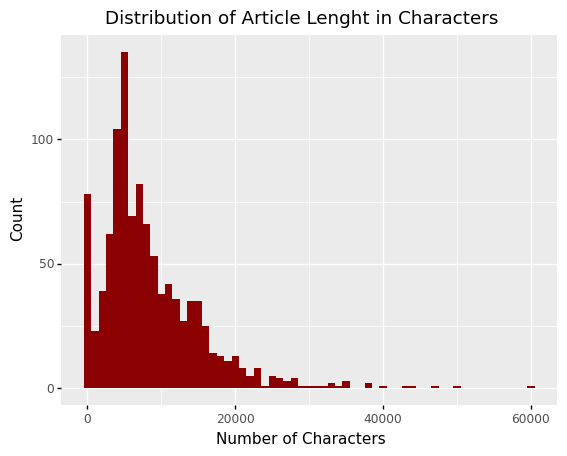

<ggplot: (8787550228745)>

In [14]:
(ggplot(article_length, aes(x="len")) +
 geom_histogram(binwidth=1000, fill="darkred") +
 ggtitle("Distribution of Article Lenght in Characters") +
 xlab("Number of Characters") +
 ylab("Count"))


In this notebook I am not going to test any hypothesis on the relationship between article length and view count. Yet i still wanted to get an idea about the spread of length of the articles

In [15]:
users_per_article.email.describe()

count    714.000000
mean      64.392157
std      109.161462
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: email, dtype: float64

In [16]:
articles_per_user.article_id.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [17]:
# Fill in the median and maximum number of user_article interactios below

median_val = int(articles_per_user.article_id.median())
max_views_by_user = int(articles_per_user.article_id.max())

print("median value is \x1b[31m {} \x1b[0m".format(int(median_val)))
print("maximum view by single user is \x1b[31m {} \x1b[0m".format(int(max_views_by_user)))

median value is  3 
maximum view by single user is  364 


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [18]:
# Find and explore duplicate articles
#duplicate articles
for column in df_content.columns:
    print("there are \x1b[31m {} \x1b[0m  duplicate values in  \x1b[31m {} \x1b[0m column".format(df_content.duplicated(column).sum(),column))

there are  19   duplicate values in   doc_body  column
there are  33   duplicate values in   doc_description  column
there are  5   duplicate values in   doc_full_name  column
there are  1055   duplicate values in   doc_status  column
there are  5   duplicate values in   article_id  column


In [19]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

In [20]:
# check if worked
print("there are \x1b[31m {} \x1b[0m  duplicate values in  \x1b[31m article_id \x1b[0m".format(df_content.article_id.duplicated().sum() ))

there are  0   duplicate values in   article_id 


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [21]:
unique_articles = df.article_id.nunique()
total_articles =  df_content.article_id.nunique()
unique_users = df.email.nunique()
user_article_interactions = df.shape[0]

In [22]:
print("There are \x1b[31m {} \x1b[0m    unique_articles".format(int(unique_articles)))
print("There are \x1b[31m {} \x1b[0m   total_articles".format(int(total_articles)))
print("There are \x1b[31m {} \x1b[0m   unique_users".format(int(unique_users)))
print("There are \x1b[31m {} \x1b[0m  user_article_interactions".format(int(user_article_interactions)))

There are  714     unique_articles
There are  1051    total_articles
There are  5148    unique_users
There are  45993   user_article_interactions


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [23]:
users_per_article

,article_id,email
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627
...,...,...
478,1113.0,1
481,1119.0,1
409,984.0,1
488,1127.0,1


In [24]:
print(users_per_article.article_id[:1].values)

[1429.]


In [25]:
most_viewed_article_id = users_per_article.article_id.head(1).values # The most viewed article in the dataset as a string with one value following the decimal
max_views = users_per_article.email.head(1).values# The most viewed article in the dataset was viewed how many times?

In [26]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [27]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id[0]),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [28]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [29]:
df.groupby("article_id")["user_id"].count().sort_values(ascending=False).reset_index()["article_id"].head()

0    1429.0
1    1330.0
2    1431.0
3    1427.0
4    1364.0
Name: article_id, dtype: float64

In [30]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    top_
    '''
    top_articles = (df.groupby("title")["user_id"].
                    count().
                    sort_values(ascending=False).
                    reset_index()["title"].
                    head(n))
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:

    '''
    top_article_ids = (df.groupby("article_id")["user_id"].
                       count().
                       sort_values(ascending=False).
                       reset_index()["article_id"].
                       head(n))
    top_article_ids = [str(ids) for ids in top_article_ids]
 
    return top_article_ids # Return the top article ids

In [31]:
print(get_top_articles(10))
print(get_top_article_ids(10))

0           use deep learning for image classification
1          insights from new york car accident reports
2                       visualize car data with brunel
3    use xgboost, scikit-learn & ibm watson machine...
4    predicting churn with the spss random tree alg...
5         healthcare python streaming application demo
6    finding optimal locations of new store using d...
7             apache spark lab, part 1: basic concepts
8              analyze energy consumption in buildings
9    gosales transactions for logistic regression m...
Name: title, dtype: object
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [32]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [33]:
unstacked = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
unstacked = unstacked.fillna(0)
for i in range(unstacked.shape[1]):
    unstacked[unstacked.columns[i]] = unstacked[unstacked.columns[i]].map(lambda x : 0 if x==0 else 1)



In [34]:
unstacked.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # create the matrix by using groupby & unstack
    user_item = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
    # the matrix has NaN values. Replace them with 0
    user_item = user_item.fillna(0)
    # For each column in the user_item matrix, replace the value with 1 if it's not 0. Keep the 0 as is.
    for i in range(user_item.shape[1]):
        user_item[user_item.columns[i]] = user_item[user_item.columns[i]].map(lambda x : 0 if x==0 else 1)

    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [36]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [37]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    # sort by similarity
    similarity = similarity.sort_values(ascending=False)
    # remove the own user's id
    similarity.drop(user_id, inplace=True)
    # create list of just the ids
    most_similar_users = list(similarity.index)

    return most_similar_users # return a list of the users in order from most to least similar
        

In [38]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user.

In [39]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # loop through article ids
    article_names = []
    for element in article_ids:
        # get actual title from data frame where id matches in title column
        article_title = df[df['article_id'] == float(element)].max()['title']
        # append to array
        article_names.append(article_title)

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # return the columns where matching user_id's have positive observations.
    user_id = int(float(user_id))
    article_ids = list(user_item.columns[np.where(user_item.loc[user_id]==1)])
    article_ids = [str(article_id) for article_id in article_ids] # store it as list
    article_names = get_article_names(article_ids)

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    try:
        #get already read articles
        already_read_ids, _ = get_user_articles(user_id)
    except KeyError: #user does not exist
        print('''\x1b[31m Either you entered an invalid user_id or the user_id you passed is not found in database.
         To unlock true potential of this recommender, please provide user_id of an existing user.
         For convenience, the engine recommends the top generic articles to new users.\x1b[0m''')
        recs = get_top_article_ids(m)
        return recs, get_article_names(recs)
    # find similar users.
    similar_users =  find_similar_users(user_id)[:m]
    # loop through all similar users to fetch article ids that they are read by the users
    pool = []
    for user in similar_users:
        # fetch the article ids
        pool.extend(set(get_user_articles(user)[0]))
        # if our user has not seen the ids found in the previous step, extend it to recs
    reccommendations = [x for x in list(dict.fromkeys(pool)) if x not in already_read_ids ][:m]


    return reccommendations

In [40]:
# check exception handling
user_user_recs(-1, 10)

 Either you entered an invalid user_id or the user_id you passed is not found in database.
         To unlock true potential of this recommender, please provide user_id of an existing user.
         For convenience, the engine recommends the top generic articles to new users.


(['1429.0',
  '1330.0',
  '1431.0',
  '1427.0',
  '1364.0',
  '1314.0',
  '1293.0',
  '1170.0',
  '1162.0',
  '1304.0'],
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model'])

In [41]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['programmatic evaluation using watson conversation',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'analyze facebook data using ibm watson and watson studio',
 'insights from new york car accident reports',
 'movie recommender system with spark machine learning',
 'ml optimization using cognitive assistant',
 'use sql with data in hadoop python',
 'brunel 2.0 preview',
 'pixiedust 1.0 is here! – ibm watson data lab',
 'from scikit-learn model to cloud with wml client']

In [42]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [43]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # calculate user-to-user similarity and store in a dataframe.
    similarity =  pd.DataFrame( {"similarity": user_item.dot(user_item.loc[user_id] ).
                                drop(user_id)} ).reset_index()
    # calculate user interactions.
    interactions = pd.DataFrame({"interaction_score":df.user_id.value_counts()})

    #merge similarty df and interactions df. Sort it by similarity and interaction score
    neighbors_df = similarity.merge(interactions,
                                    left_on='user_id',
                                    right_index=True).\
        rename(columns={"user_id":"neighbour_id"}).\
        sort_values(by=['similarity', 'interaction_score'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # first, check if the user_id input is valid. If not, tell what went wrong
    try:
        #get already read articles
        already_read_ids, _ = get_user_articles(user_id)
    except KeyError: #user does not exist
        print('''\x1b[31m Either you entered an invalid user_id or the user_id you passed is not found in database.
         To unlock true potential of this recommender, please provide user_id of an existing user.
         For convenience, the engine recommends the top generic articles to new users.\x1b[0m''')
        recs = get_top_article_ids(m)
        return recs, get_article_names(recs)
    # get top neighbor_id's of top "m times 2" similar users that have high interaction_score values.
    # if you want to make 1 recommendation, pool articles from 2 similar users, for two recommendations 4 etc.
    # this is a dangerous way of doing it because an outlier user who read many articles can break the system
    neighbour_id = list(get_top_sorted_users(user_id)["neighbour_id"])[:2*m]

    # Pool all the articles that are read by similar users
    pool = []
    for neighbour in neighbour_id:
        # fetch the article ids
        pool.extend(set(get_user_articles(neighbour)[0]))
        # if our user has not seen the ids found in the previous step, extend it to recs
    reccommendations = [x for x in list(dict.fromkeys(pool)) if x not in already_read_ids ][:m]
        # Exit for forcefully when m (iteration number) is met.



    return reccommendations, get_article_names(reccommendations)

In [44]:
# check if function can deal with non-users as intended
user_user_recs_part2(-2, 3)[1]

 Either you entered an invalid user_id or the user_id you passed is not found in database.
         To unlock true potential of this recommender, please provide user_id of an existing user.
         For convenience, the engine recommends the top generic articles to new users.


['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel']

In [45]:
# Check if the functions recommendations are from a similar domain (subjective evaluation)
user_user_recs_part2(1, 10)[1]

['programmatic evaluation using watson conversation',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'analyze facebook data using ibm watson and watson studio',
 'insights from new york car accident reports',
 'movie recommender system with spark machine learning',
 'ml optimization using cognitive assistant',
 'use sql with data in hadoop python',
 'brunel 2.0 preview',
 'pixiedust 1.0 is here! – ibm watson data lab',
 'from scikit-learn model to cloud with wml client']

In [46]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user \x1b[31m 20 \x1b[0m are the following article ids:")
print("\x1b[31m {} \x1b[0m".format(rec_ids))
print()
print("The top 10 recommendations for user \x1b[31m 20 \x1b[0m are the following article names:")
print("\x1b[31m {} \x1b[0m".format(rec_names))

The top 10 recommendations for user  20  are the following article ids:
 ['1024.0', '1157.0', '1276.0', '880.0', '1351.0', '1367.0', '911.0', '555.0', '1330.0', '681.0'] 

The top 10 recommendations for user  20  are the following article names:
 ['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: washington d.c. listings', 'deploy your python model as a restful api', 'probabilistic graphical models tutorial\u200a—\u200apart 1 – stats and bots', 'model bike sharing data with spss', 'programmatic evaluation using watson conversation', 'using machine learning to predict baseball injuries', 'build a naive-bayes model with wml & dsx', 'insights from new york car accident reports', 'real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)'] 


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [47]:
print(get_top_sorted_users(1)['neighbour_id'].iloc[0])
print(get_top_sorted_users(131)['neighbour_id'].iloc[9])

3933
242


In [48]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbour_id'].iloc[0] # Find the user that is most similar to user 1
user131_10th_sim = get_top_sorted_users(131)['neighbour_id'].iloc[9] # Find the 10th most similar user to user 131

In [49]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For the new users, quick and dirty way solution is to recommend top articles. However, a welcoming page where user picks their topics of interests from the tags pool would be better. From there on, we can recommend top articles within each tag that user picked. That would be a hybrid system of knowledge based and ranking based filtering.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [50]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs, _ = user_user_recs_part2('0.0', 10)# Your recommendations here



 Either you entered an invalid user_id or the user_id you passed is not found in database.
         To unlock true potential of this recommender, please provide user_id of an existing user.
         For convenience, the engine recommends the top generic articles to new users.


In [51]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [52]:
# Load the matrix here
#user_item_matrix = pd.read_pickle('user_item_matrix.p')

## I commented out these because user_item_matrix is already in the memory.

In [53]:
# quick look at the matrix
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [54]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item)

**Provide your response here.*

Classic singular value decomposition can't cope with missing values. In the course section, we had examples where there were missing observations in the data. However, in the current notebook, user_item matrix has no missing values. Thus we can perform SVD right away.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [55]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


In [56]:
accuracy_vs_nlf_train = pd.DataFrame({"num_latent_feats":num_latent_feats,"error": 1 - np.array(sum_errs) / df.shape[0]} )

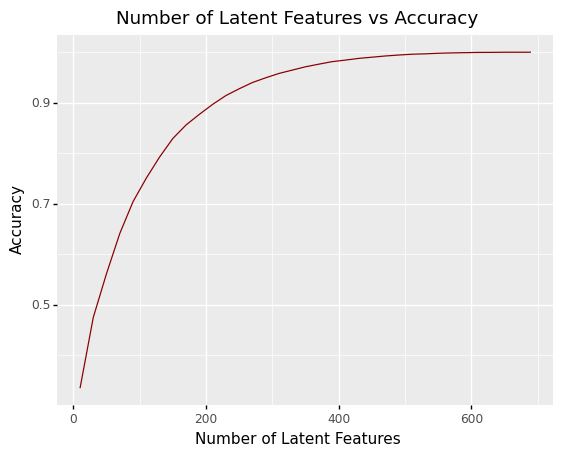

<ggplot: (8787551105573)>

In [57]:
(ggplot(accuracy_vs_nlf_train,
        aes(x="num_latent_feats", y="error")) +
 geom_line(color="darkred") +
 ggtitle("Number of Latent Features vs Accuracy") +
 xlab("Number of Latent Features") +
 ylab("Accuracy")
 )


`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [58]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # convert train and test dataframes to user-item-matrix format by using the function
    # that we described on top of the partIII.
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # grap the index and columns.
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts # return all

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [59]:
print(len(test_idx))
print(len(test_arts))
print(user_item_train.shape)
print(user_item_test.shape)

682
574
(4487, 714)
(682, 574)


In [60]:
# completely new users.
cold_start_users = len(set(test_idx) -set(user_item_train.index))
common_users = len(test_idx) - cold_start_users
cold_start_articles = len(set(test_arts) -set(user_item_train.columns))
# since cold start articles is zero, no need for calculating common articles. It's shape[1] of test set

print("Number of users that are only in test set but not in the training is {}".format(cold_start_users))
print("number of user that are in both sets is {}".format(common_users))
print("Number of articles are only in test set but not in the training is {}".format(cold_start_articles))
print("Number of articles that are in both sets is {}".format(user_item_test.shape[1]))

#

Number of users that are only in test set but not in the training is 662
number of user that are in both sets is 20
Number of articles are only in test set but not in the training is 0
Number of articles that are in both sets is 574


In [61]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a,
    'How many articles can we make predictions for in the test set?':b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [62]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [63]:
common_users = np.intersect1d(test_idx,  user_item_train.index)
common_user_item = user_item_test.loc[common_users]
print('test: ', common_users.shape, common_user_item.shape)

test:  (20,) (20, 574)


In [64]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # Restructure matrices with k latent features
    u_train_new = u_train[:, :k]
    s_train_new = np.diag(s_train[:k])
    vt_train_new = vt_train[:k, :]

    # Taken the subset of the u_train and vt_train matrices with users and articles present in the user_item_test matrix
    u_train_subset = u_train_new[user_item_train.index.isin(test_idx), :]
    vt_train_subset = vt_train_new[:, user_item_train.columns.isin(test_arts)]

    # Create user_item_estimate matrix using the subset of u_train and vt_train
    predictions = np.around(np.dot(np.dot(u_train_subset, s_train_new), vt_train_subset))

    # Determine the error between each user_item interaction in the test set and the user_item_estimate matrix
    errors = np.abs(np.subtract(common_user_item, predictions))

    # Find the total error for each user
    sum_error = np.sum(errors.sum())

    # Append the total error to the list of errors
    sum_errs.append(sum_error)


In [66]:
accuracy_vs_nlf_test = pd.DataFrame(
    {"num_latent_feats": num_latent_feats, "error": 1 - np.array(sum_errs) / df.shape[0]})

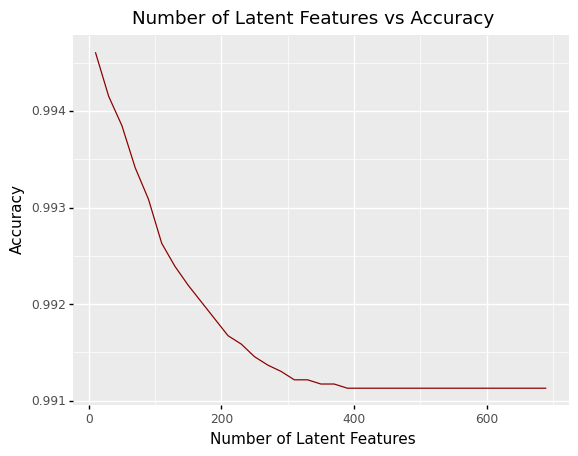

<ggplot: (8787484582109)>

In [67]:
(ggplot(accuracy_vs_nlf_test,
        aes(x="num_latent_feats", y="error")) +
 geom_line(color="darkred") +
 ggtitle("Number of Latent Features vs Accuracy") +
 xlab("Number of Latent Features") +
 ylab("Accuracy")
 )


The function above is mainly derived from the notebook here
>https://github.com/samarasadeek/Udacity_DSProject3_Recommendation_System/blob/main/Recommendations_project.ipynb

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

## Diagnosis
When we plot accuracy vs number of features function, we can clearly see that there's a divergence in training and test sets. It's a sign of **overfitting**. In order to prevent it we have to clearly identify why it's happening.
Is it mainly because **large feature size** or mainly because **small N**?
We have ~ 5k unique users and around 700 unique articles. And we also saw above that there are only 20 users that we can make new predictions on. This is too small for sample size for reaching any conclusions.

Gradually this number will increase as the new users start interacting with some articles. However, there's a danger lurking around. *So far we have only implemented **rank based filtering** for the new users*. If we do not add **serendipity layer** to the system to diversify initial recommendations, then it means that we would be *actively pushing users to interact with only limited fragment(top articles) of our data**. This is dangerous because we are creating an echo wall for our users. One can even say, we are not learning from user preferences but rather users are pushed towards sweet-spot of our algorithm.



